# SEGMENTATION PAR RFM DES CLIENTS OLIST

Pourquoi réaliser une segmentation client ?

L’objectif principal de cette démarche est de mieux comprendre notre clientèle afin de soutenir la prise de décision stratégique. Elle permet de répondre à des questions clés telles que :

- Qui sont nos clients les plus rentables et à forte valeur ajoutée ?
- Quels aspects de nos produits ou services sont les plus appréciés par nos clients ?
- Qui sont nos nouveaux clients et comment les engager efficacement dès leurs premiers achats ?
- Comment optimiser nos canaux de communication pour améliorer la relation client et la pertinence de nos messages ?
- Quelles actions mettre en place pour attirer de nouveaux clients et fidéliser les clients existants ?
- Les réponses à ces questions résident dans une segmentation client pertinente et structurée. En identifiant des groupes de clients aux comportements et aux besoins similaires, l’entreprise peut adapter ses stratégies marketing, commerciales et relationnelles à chaque segment.
  
Grâce à une segmentation affinée, il devient possible de proposer des actions ciblées, personnalisées et plus efficaces, répondant aux préférences spécifiques de chaque segment, tout en maximisant la satisfaction client et la performance globale de l’entreprise.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import plotly.express as px
import squarify
import datetime as dt

## Chargement & préparation des données

In [10]:
# ===================================================================
# Chargement des données brutes
# ======================================================================

DATA_PATH = Path("/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees")  

DATE_COLS = [
    "shipping_limit_date",
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_creation_date",
    "review_answer_timestamp",
]

def load_olist_master(path: str | Path = DATA_PATH) -> pd.DataFrame:
    
    df = pd.read_csv(path)

    # Conversion des dates
    for col in DATE_COLS:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    return df

# Préparation de base pour la segmentation
Nettoyage minimal pour la segmentation client :
- garde uniquement les commandes livrées
- supprime les doublons (order_id, customer_unique_id)
- garde les colonnes utiles (RFM + variables comportementales)

In [11]:
def prepare_base_for_segmentation(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()

    # Ici, on garde uniquement les commandes livrées
    if "order_status" in df.columns:
        df = df[df["order_status"] == "delivered"]

    # Suppression des doublons éventuels
    df = df.drop_duplicates(subset=["order_id", "customer_unique_id"])
def prepare_base_for_segmentation(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()

    # Ici, on garde uniquement les commandes livrées
    if "order_status" in df.columns:
        df = df[df["order_status"] == "delivered"]

    # Suppression des doublons éventuels
    df = df.drop_duplicates(subset=["order_id", "customer_unique_id"])

    # Colonnes utiles pour RFM + modèles
    cols_needed = [
        "order_id",
        "customer_unique_id",
        "order_purchase_timestamp",
        "payment_value",
        "review_score",
        "payment_installments",
        "product_photos_qty",
        "price",
        "customer_city",
        "customer_state",
        "product_category_name",
    ]

    cols_present = [c for c in cols_needed if c in df.columns]
    df = df[cols_present]

    # Suppression des lignes sans infos essentielles
    df = df.dropna(subset=["customer_unique_id", "order_purchase_timestamp", "payment_value"])

    return df


# ===========================================================================
# Utilisation de la fonction load_olist_master
# ==========================================================================

# if __name__ == "__main__":
data_raw = load_olist_master("/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/olist_dataset.csv")
df_seg_base = prepare_base_for_segmentation(data_raw)
print(df_seg_base.info())
df_seg_base.head()
    # Colonnes utiles pour RFM + modèles
    cols_needed = [
        "order_id",
        "customer_unique_id",
        "order_purchase_timestamp",
        "payment_value",
        "review_score",
        "payment_installments",
        "product_photos_qty",
        "price",
        "customer_city",
        "customer_state",
        "product_category_name",
    ]

    cols_present = [c for c in cols_needed if c in df.columns]
    df = df[cols_present]

    # Suppression des lignes sans infos essentielles
    df = df.dropna(subset=["customer_unique_id", "order_purchase_timestamp", "payment_value"])

    return df


# ===========================================================================
# Utilisation de la fonction load_olist_master
# ==========================================================================

# if __name__ == "__main__":
data_raw = load_olist_master("/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/olist_dataset.csv")
df_seg_base = prepare_base_for_segmentation(data_raw)
print(df_seg_base.info())
df_seg_base.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96477 entries, 0 to 115722
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96477 non-null  object        
 1   customer_unique_id        96477 non-null  object        
 2   order_purchase_timestamp  96477 non-null  datetime64[ns]
 3   payment_value             96477 non-null  float64       
 4   review_score              95831 non-null  float64       
 5   payment_installments      96477 non-null  float64       
 6   product_photos_qty        95118 non-null  float64       
 7   price                     96477 non-null  float64       
 8   customer_city             96477 non-null  object        
 9   customer_state            96477 non-null  object        
 10  product_category_name     95118 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 8.8+ MB
None


,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score,payment_installments,product_photos_qty,price,customer_city,customer_state,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,72.19,5.0,2.0,4.0,58.90,campos dos goytacazes,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,259.83,4.0,3.0,2.0,239.90,santa fe do sul,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,216.87,5.0,5.0,2.0,199.00,para de minas,MG,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,25.78,4.0,2.0,1.0,12.99,atibaia,SP,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,218.04,5.0,3.0,1.0,199.90,varzea paulista,SP,ferramentas_jardim


## Traitement robuste des variables monétaires :
- winsorisation (cap des valeurs extrêmes)
- transformation logarithmique

In [3]:
def preprocess_monetary_features(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()

    # Sécurité : éviter valeurs négatives
    df = df[df["payment_value"] >= 0]

    # Winsorisation à 1% 
    df["payment_value_wins"] = winsorize(
        df["payment_value"], limits=[0, 0.01]
    )

    # Log transform pour réduire l'asymétrie
    df["payment_value_log"] = np.log1p(df["payment_value_wins"])

    # Même logique pour le prix si utilisé plus tard
    if "price" in df.columns:
        df["price_wins"] = winsorize(df["price"], limits=[0, 0.01])
        df["price_log"] = np.log1p(df["price_wins"])

    return df

## Segmentation RFM
- Calcule DE la table RFM à partir de données prétraitées.
- Monetary basé sur une version log-transformée (robuste).

In [4]:
def compute_rfm_table(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()

    max_date = df["order_purchase_timestamp"].max()
    NOW = max_date + pd.Timedelta(days=1)

    rfm = (
        df.groupby("customer_unique_id")
        .agg(
            recency=("order_purchase_timestamp", lambda x: (NOW - x.max()).days),
            frequency=("order_id", "nunique"),
            monetary_value=("payment_value_log", "sum"),
        )
    )

    rfm["recency"] = rfm["recency"].astype(int)
    rfm["frequency"] = rfm["frequency"].astype(int)
    rfm["monetary_value"] = rfm["monetary_value"].astype(float)

    return rfm

## Ajout des scores R, F, M (1–5) et une étiquette de segment marketing.
Convention des scores :
- Recency_score : 5 = très récent, 1 = très ancien
- Frequency_score : 5 = très fréquent, 1 = très rare
- Monetary_score : 5 = dépense élevée, 1 = dépense faible

In [5]:
def add_rfm_scores_and_segments(rfm: pd.DataFrame) -> pd.DataFrame:
    """
    Ajoute :
    - scores R, F, M (1–5)
    - scores RF et RFM
    - segment marketing RFM
    """

    rfm = rfm.copy()

    # ======================================================
    # 1. Scores R, F, M (avec fallback)
    # ======================================================

    # RECENCY
    try:
        rfm["recency_score"] = pd.qcut(
            rfm["recency"], 5, labels=[5, 4, 3, 2, 1]
        )
    except Exception:
        rfm["recency_score"] = pd.cut(
            rfm["recency"], bins=5, labels=[5, 4, 3, 2, 1]
        )

    # FREQUENCY
    try:
        rfm["frequency_score"] = pd.qcut(
            rfm["frequency"].rank(method="first"),
            5,
            labels=[1, 2, 3, 4, 5]
        )
    except Exception:
        rfm["frequency_score"] = pd.cut(
            rfm["frequency"], bins=5, labels=[1, 2, 3, 4, 5]
        )

    # MONETARY
    try:
        rfm["monetary_score"] = pd.qcut(
            rfm["monetary_value"].rank(method="first"),
            5,
            labels=[1, 2, 3, 4, 5]
        )
    except Exception:
        rfm["monetary_score"] = pd.cut(
            rfm["monetary_value"], bins=5, labels=[1, 2, 3, 4, 5]
        )

    # Cast sécurité
    rfm[["recency_score", "frequency_score", "monetary_score"]] = (
        rfm[["recency_score", "frequency_score", "monetary_score"]]
        .astype(int)
    )

    # ======================================================
    # 2. Scores combinés
    # ======================================================
    rfm["rf_score"] = (
        rfm["recency_score"].astype(str)
        + rfm["frequency_score"].astype(str)
    )

    rfm["rfm_score"] = (
        rfm["recency_score"].astype(str)
        + rfm["frequency_score"].astype(str)
        + rfm["monetary_score"].astype(str)
    )

    # ======================================================
    # 3. Mapping métier RFM
    # ======================================================
    def segment_from_rfm(row):
        r, f, m = row["recency_score"], row["frequency_score"], row["monetary_score"]

        if r >= 4 and f >= 4 and m >= 4:
            return "champions"
        if r >= 4 and f >= 4:
            return "clients_fideles"
        if r >= 4 and f >= 3 and m >= 3:
            return "clients_prometteurs"
        if r >= 4 and f <= 2:
            return "nouveaux_clients"
        if r >= 3 and f <= 2 and m >= 2:
            return "clients_a_surveiller"
        if r == 3 and f >= 3:
            return "clients_a_ne_pas_perdre"
        if r <= 2 and (f >= 3 or m >= 4):
            return "clients_a_reactiver"
        if r <= 2 and f <= 2 and m <= 2:
            return "clients_perdus"
        if r <= 2 and f <= 2:
            return "clients_en_risque"
        return "autres"

    rfm["segment"] = rfm.apply(segment_from_rfm, axis=1)

    return rfm

## Treemap des segments RFM.
- Affiche un message si aucun segment n'est disponible.

In [6]:
def plot_rfm_treemap(rfm: pd.DataFrame):
    
    if "segment" not in rfm.columns or rfm["segment"].nunique() == 0:
        print("Aucun segment disponible pour affichage (RFM vide).")
        return

    counts = rfm["segment"].value_counts()
    labels = [f"{seg}\n({cnt})" for seg, cnt in counts.items()]
    colors = sns.color_palette("Spectral", n_colors=len(counts))

    plt.figure(figsize=(12, 8))
    squarify.plot(
        sizes=counts.values,
        label=labels,
        alpha=0.85,
        color=colors,
        text_kwargs={"fontsize": 10}
    )
    plt.axis("off")
    plt.title("Répartition des segments RFM", fontsize=18)
    plt.tight_layout()
    plt.show()

def plot_rfm_bar_pie(rfm):
    counts = rfm["segment"].value_counts()
    total = counts.sum()

    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(x=counts.index, hue=counts.index, y=counts.values, palette="viridis", ax=ax)
    for i, v in enumerate(counts.values):
        ax.text(i, v, f"{v} ({v/total:.1%})", ha="center", va="bottom")

    ax.set_title("Nombre de clients par segment RFM")
    ax.set_xlabel("Segment")
    ax.set_ylabel("Nombre de clients")
    plt.xticks(rotation=45)
    return fig

    # Pie chart
    plt.figure(figsize=(8, 8))
    explode = [0.05] + [0] * (len(counts) - 1)
    plt.pie(
        counts.values,
        labels=counts.index,
        autopct="%1.1f%%",
        startangle=90,
        explode=explode
    )
    plt.title("Proportion des clients par segment RFM", fontsize=16)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

## Affichage d’un tableau de synthèse agrégé par segment client :
- recency moyenne
- frequency moyenne
- monetary moyenne
- taille du segment

In [7]:
def summarize_rfm_segments(rfm: pd.DataFrame) -> pd.DataFrame:
    summary = (
        rfm.groupby("segment")[["recency", "frequency", "monetary_value"]]
        .agg(["mean", "count"])
        .sort_values(("monetary_value", "mean"), ascending=False)
    )
    return summary

## Execution de pipeline complet

segment
clients_a_reactiver        27851
nouveaux_clients           14984
clients_a_ne_pas_perdre    11336
clients_fideles             8325
champions                   6636
clients_perdus              6360
clients_a_surveiller        5821
autres                      4570
clients_prometteurs         4470
clients_en_risque           3004
Name: count, dtype: int64


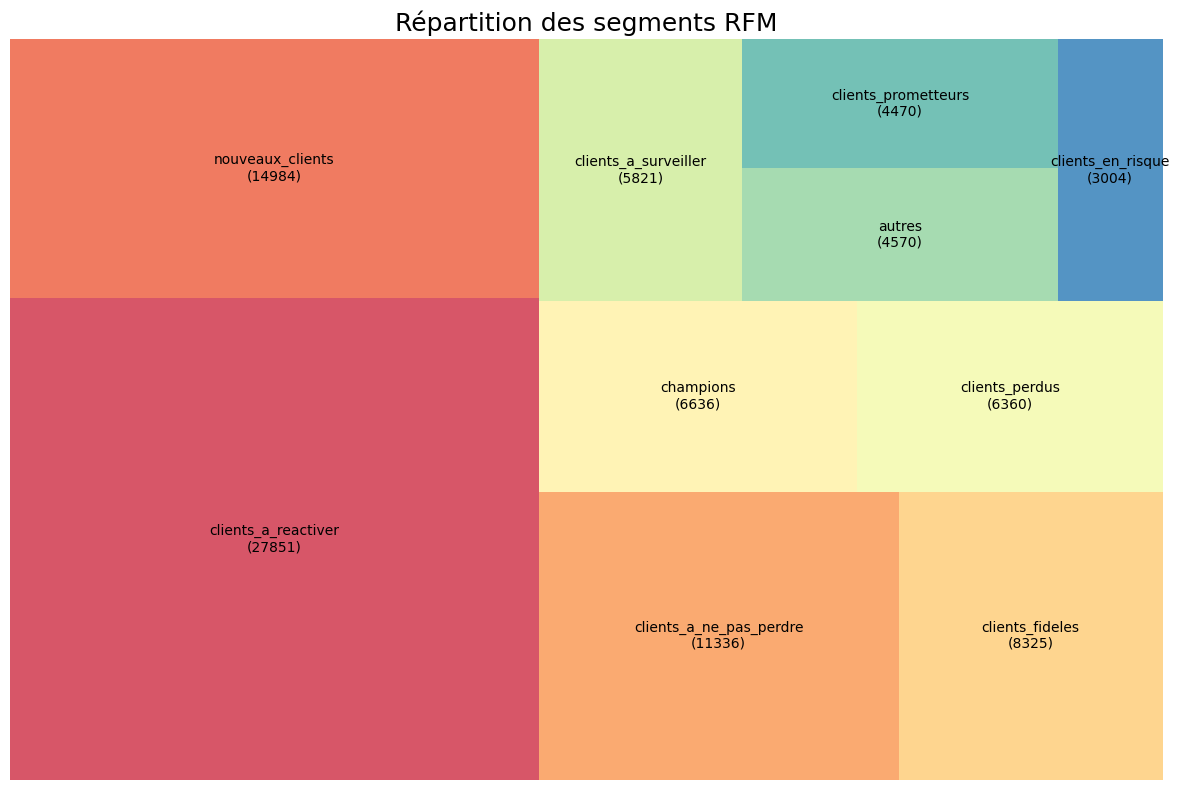

recency        frequency        monetary_value  \
                               mean  count      mean  count           mean   
segment                                                                      
champions                 91.097197   6636  1.209916   6636       6.303183   
clients_prometteurs       92.164877   4470  1.000000   4470       5.213765   
clients_a_reactiver      394.510933  27851  1.038311  27851       4.999130   
clients_a_surveiller     220.586154   5821  1.000000   5821       4.940620   
clients_a_ne_pas_perdre  220.450423  11336  1.058045  11336       4.914056   
nouveaux_clients          90.878404  14984  1.000000  14984       4.693780   
clients_en_risque        394.675766   3004  1.000000   3004       4.683445   
clients_fideles           89.542583   8325  1.000240   8325       4.168112   
clients_perdus           397.261321   6360  1.000000   6360       3.924152   
autres                   132.740044   4570  1.000000   4570       3.791777   

                                
                         count  
segment                         
champions                 6636  
clients_prometteurs       4470  
clients_a_reactiver      27851  
clients_a_surveiller      5821  
clients_a_ne_pas_perdre  11336  
nouveaux_clients         14984  
clients_en_risque         3004  
clients_fideles           8325  
clients_perdus            6360  
autres                    4570

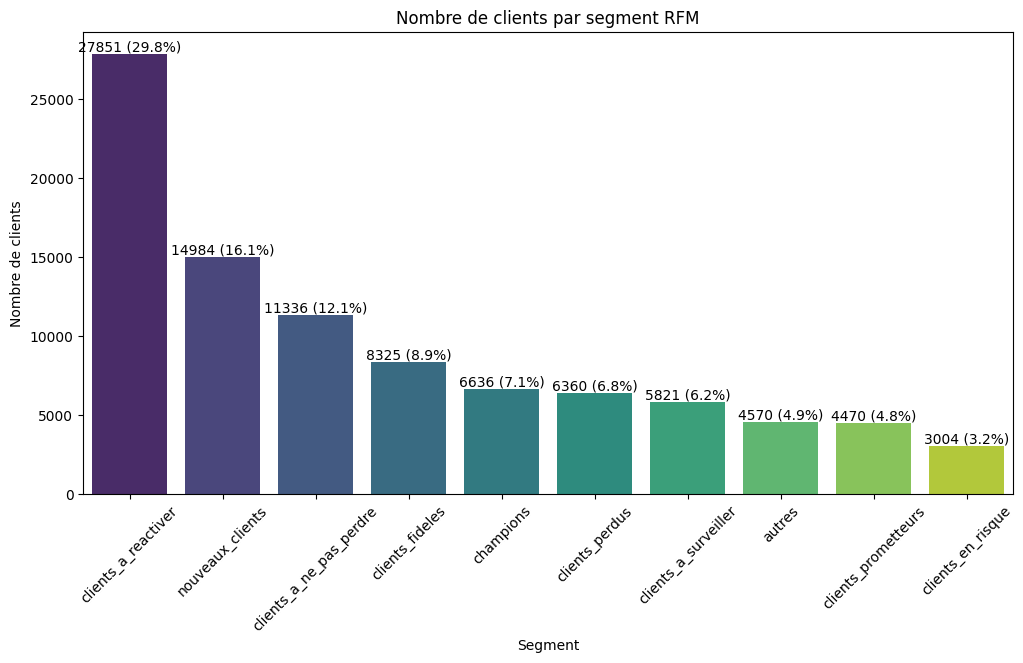

In [12]:
# Copie de la base
df_rfm = df_seg_base.copy()

# Nettoyage de base
df_clean = prepare_base_for_segmentation(df_rfm)

# Traitement robuste des outliers
df_clean = preprocess_monetary_features(df_clean)

# RFM
rfm = compute_rfm_table(df_clean)
rfm = add_rfm_scores_and_segments(rfm)
print(rfm["segment"].value_counts())

# Analyse & visualisation
plot_rfm_treemap(rfm)
plot_rfm_bar_pie(rfm)

# Tableau de synthèse agrégé par segment client 
summarize_rfm_segments(rfm)

La grille RFM représentée sous forme de treemap illustre une pratique de segmentation largement adoptée par les entreprises pour mieux comprendre et structurer leur base clients. Elle constitue un outil d’aide à la décision essentiel pour la planification stratégique de campagnes marketing ciblées, permettant d’adresser chaque segment de manière pertinente et efficace.

En s’appuyant sur l’analyse conjointe de la récence, de la fréquence et de la valeur monétaire des transactions, les organisations obtiennent une vision approfondie des comportements d’achat de leurs clients. Ces informations facilitent l’adaptation des actions marketing et commerciales aux besoins, au potentiel et au niveau d’engagement de chaque segment.

Cette approche data-driven contribue à renforcer l’engagement client, à améliorer la fidélisation et, in fine, à soutenir durablement la performance globale de l’entreprise.

## Exportation des données issues de l’analyse RFM au format CSV

In [9]:
# Après prepare_base_for_segmentation
df_seg_base.to_csv(
    "/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/df_seg_base.csv.csv",
    index=False
)